In [1]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=05eda7a5f0b1d17cd19d6e161a37fd40c6e64f1258835a5259c9b508806a8462
  Stored in directory: /root/.cache/pip/wheels/82/d8/73/e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap


In [2]:
!pip install umap-learn


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap
import scipy.cluster.hierarchy as sch
from xgboost import XGBClassifier
import shap


In [4]:
from google.colab import files
uploaded = files.upload()

Saving credit_risk.csv to credit_risk.csv


In [5]:
data = pd.read_csv('credit_risk.csv')
data

,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
16709,1.000000,46.0,0.0,170.398010,401.0,3.0,2.0,0.0,0.0,2.0,1
16710,1.135552,41.0,2.0,0.845887,7500.0,12.0,0.0,4.0,1.0,0.0,1
16711,0.920107,31.0,1.0,0.176732,1125.0,4.0,1.0,0.0,0.0,0.0,1
16712,0.983825,55.0,0.0,0.064116,4600.0,2.0,1.0,0.0,0.0,6.0,1


# EDA

In [7]:
print(data.describe())

           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16714.000000  16714.000000  16714.000000  16714.000000   16714.000000   
mean       4.799862     48.798672      1.110267     30.980298    6118.120258   
std      204.062345     13.906078      7.172890    719.694859    5931.841779   
min        0.000000     21.000000      0.000000      0.000000       0.000000   
25%        0.082397     38.000000      0.000000      0.155971    3128.500000   
50%        0.443080     48.000000      0.000000      0.322299    5000.000000   
75%        0.926637     58.000000      1.000000      0.533426    7573.000000   
max    22000.000000    101.000000     98.000000  61106.500000  250000.000000   

        open_credit       late_90   real_estate    late_60_89    dependents  \
count  16714.000000  16714.000000  16714.000000  16714.000000  16714.000000   
mean       8.503709      0.863827      1.047445      0.734354      0.944358   
std        5.370965      7.167576      1.2

In [8]:
import plotly.express as px

corr = data.corr()
fig = px.imshow(corr,
                text_auto=True,
                color_continuous_scale='RdBu_r',
                title='Matriz de Correlación')
fig.show()


In [10]:
for col in ['debt_ratio', 'monthly_inc', 'rev_util']:
    data[col] = data[col].clip(upper=data[col].quantile(0.99))
data['monthly_inc'] = data['monthly_inc'].replace(0, data['monthly_inc'].median())

data['late_total'] = data['late_30_59'] + data['late_60_89'] + data['late_90']
data['debt_load'] = data['debt_ratio'] * data['monthly_inc']

X = data.drop('dlq_2yrs', axis=1)
y = data['dlq_2yrs']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means

In [11]:
k_range = range(2, 7)
inertia = []
silhouette_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

# Codo
fig = px.line(x=list(k_range), y=inertia,
              title='Método del Codo para K-means',
              labels={'x': 'Número de Clusters', 'y': 'Inercia (WCSS)'})
fig.show()

# Silhouette Score
fig = px.line(x=list(k_range), y=silhouette_scores,
              title='Silhouette Score por Número de Clusters (K-means)',
              labels={'x': 'Número de Clusters', 'y': 'Silhouette Score'})
fig.show()

#Davies-Bouldin Score
fig = px.line(x=list(k_range), y=davies_bouldin_scores,
              title='Davies-Bouldin Score por Número de Clusters (K-means)',
              labels={'x': 'Número de Clusters', 'y': 'Davies-Bouldin Score'})
fig.show()

print("K-means - Métricas por número de clusters:")
for k, sil, db in zip(k_range, silhouette_scores, davies_bouldin_scores):
    print(f"Clusters: {k}, Silhouette: {sil:.3f}, Davies-Bouldin: {db:.3f}")



K-means - Métricas por número de clusters:
Clusters: 2, Silhouette: 0.190, Davies-Bouldin: 1.993
Clusters: 3, Silhouette: 0.199, Davies-Bouldin: 1.311
Clusters: 4, Silhouette: 0.177, Davies-Bouldin: 1.454
Clusters: 5, Silhouette: 0.178, Davies-Bouldin: 1.439
Clusters: 6, Silhouette: 0.200, Davies-Bouldin: 1.141


In [65]:
import umap.umap_ as umap

# UMAP 2D
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(X_scaled)

kmeans_opt = KMeans(n_clusters=2, random_state=42)
kmeans_opt.fit(X_scaled)

# Visualización
fig = px.scatter(x=X_umap[:, 0], y=X_umap[:, 1],
                 color=kmeans_opt.labels_.astype(str),
                 title='K-means (k=2) en Espacio UMAP')
fig.show()



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [66]:
data['cluster_kmeans'] = kmeans_opt.labels_
cluster_summary_kmeans = data.groupby('cluster_kmeans').mean(numeric_only=True)
print("\nResumen de Clusters (K-means, k=2):")
display(cluster_summary_kmeans)


Resumen de Clusters (K-means, k=2):


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs,late_total,debt_load,cluster_hc,cluster_gmm
cluster_kmeans,,,,,,,,,,,,,,,
0,0.759110,40.886993,1.864802,7.718083,4146.721780,5.478707,1.711262,0.477937,1.441380,1.052719,0.664828,5.017445,27750.817429,1.988584,0.925603
1,0.271165,55.714959,0.450662,1.729333,7614.290536,11.148127,0.123010,1.545302,0.116282,0.849630,0.355909,0.689953,7397.350239,2.000000,0.960417


# Jerárquico

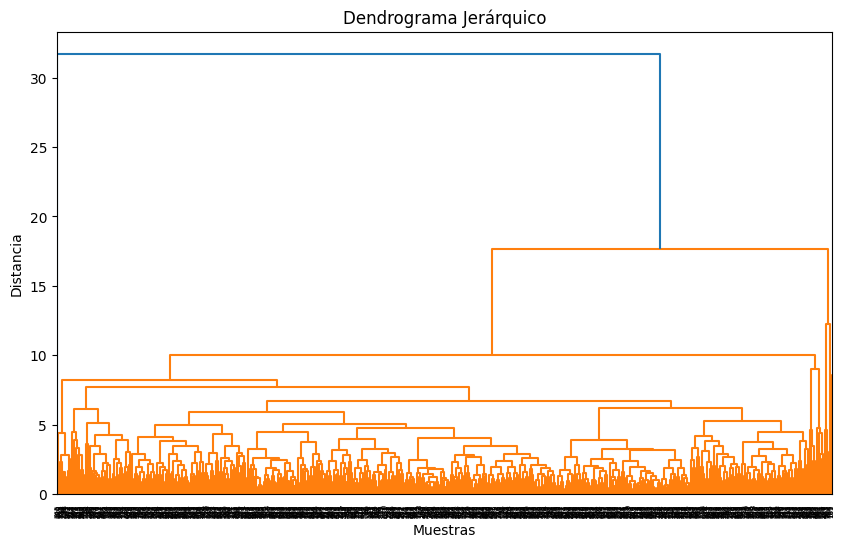


Clustering Jerárquico - Métricas por número de clusters:
Clusters: 2, Silhouette: 0.882, Davies-Bouldin: 0.082
Clusters: 3, Silhouette: 0.759, Davies-Bouldin: 0.471
Clusters: 4, Silhouette: 0.662, Davies-Bouldin: 0.613
Clusters: 5, Silhouette: 0.400, Davies-Bouldin: 0.869
Clusters: 6, Silhouette: 0.341, Davies-Bouldin: 0.746


In [14]:
Z = sch.linkage(X_scaled[:1000], method='complete')

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(Z)
plt.title('Dendrograma Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()


silhouette_hc = []
davies_bouldin_hc = []

for k in k_range:
    hc = sch.fcluster(Z, t=k, criterion='maxclust')
    if len(np.unique(hc)) == k:  # Asegurar que se formen k clusters
        silhouette_hc.append(silhouette_score(X_scaled[:1000], hc))
        davies_bouldin_hc.append(davies_bouldin_score(X_scaled[:1000], hc))
    else:
        silhouette_hc.append(np.nan)
        davies_bouldin_hc.append(np.nan)


fig = px.line(x=list(k_range), y=silhouette_hc,
              title='Silhouette Score por Número de Clusters (Jerárquico)',
              labels={'x': 'Número de Clusters', 'y': 'Silhouette Score'})
fig.show()

fig = px.line(x=list(k_range), y=davies_bouldin_hc,
              title='Davies-Bouldin Score por Número de Clusters (Jerárquico)',
              labels={'x': 'Número de Clusters', 'y': 'Davies-Bouldin Score'})
fig.show()


print("\nClustering Jerárquico - Métricas por número de clusters:")
for k, sil, db in zip(k_range, silhouette_hc, davies_bouldin_hc):
    print(f"Clusters: {k}, Silhouette: {sil:.3f}, Davies-Bouldin: {db:.3f}")


In [60]:
hc_opt = sch.fcluster(sch.linkage(X_scaled, method='complete'), t=2, criterion='maxclust')

fig = px.scatter(x=X_umap[:, 0],
                 y=X_umap[:, 1],
                 color=hc_opt.astype(str),  # Convertir a string para color categórico
                 title='Clustering Jerárquico (k=2) en Espacio UMAP')
fig.show()



In [23]:
data['cluster_hc'] = hc_opt
cluster_summary_hc = data.groupby('cluster_hc').mean(numeric_only=True)
print("\nResumen de Clusters (Jerárquico, k=2):")
display(cluster_summary_hc)


Resumen de Clusters (Jerárquico, k=3):


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs,late_total,debt_load,cluster_kmeans
cluster_hc,,,,,,,,,,,,,,
1,1.000000,37.022472,97.932584,0.004928,2535.191011,0.011236,97.932584,0.000000,97.932584,0.651685,0.943820,293.797753,10.613050,1.000000
2,0.496077,48.861714,0.591940,4.546883,6015.425805,8.549173,0.344180,1.053053,0.214015,0.945925,0.497624,1.150135,16981.293085,1.032421


# GMM

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import plotly.express as px

silhouette_gmm = []
davies_bouldin_gmm = []
k_range = range(2, 7)

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    if len(np.unique(labels)) == k:
        silhouette_gmm.append(silhouette_score(X_scaled, labels))
        davies_bouldin_gmm.append(davies_bouldin_score(X_scaled, labels))
    else:
        silhouette_gmm.append(np.nan)
        davies_bouldin_gmm.append(np.nan)

#Silhouette Score
fig = px.line(x=list(k_range), y=silhouette_gmm,
              title='Silhouette Score por Número de Clusters (GMM)',
              labels={'x': 'Número de Clusters', 'y': 'Silhouette Score'})
fig.show()

#Davies-Bouldin Score
fig = px.line(x=list(k_range), y=davies_bouldin_gmm,
              title='Davies-Bouldin Score por Número de Clusters (GMM)',
              labels={'x': 'Número de Clusters', 'y': 'Davies-Bouldin Score'})
fig.show()

print("\nGMM - Métricas por número de clusters:")
for k, sil, db in zip(k_range, silhouette_gmm, davies_bouldin_gmm):
    print(f"Clusters: {k}, Silhouette: {sil:.3f}, Davies-Bouldin: {db:.3f}")



GMM - Métricas por número de clusters:
Clusters: 2, Silhouette: 0.559, Davies-Bouldin: 2.624
Clusters: 3, Silhouette: 0.198, Davies-Bouldin: 2.778
Clusters: 4, Silhouette: 0.037, Davies-Bouldin: 2.384
Clusters: 5, Silhouette: 0.034, Davies-Bouldin: 2.310
Clusters: 6, Silhouette: 0.035, Davies-Bouldin: 2.384


In [59]:
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(X_scaled)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

fig = px.scatter(x=X_umap[:, 0],
                 y=X_umap[:, 1],
                 color=gmm_labels.astype(str),
                 title='GMM (k=2) en Espacio UMAP')
fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [44]:
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_scaled)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

fig = px.scatter_3d(x=X_umap_3d[:, 0],
                    y=X_umap_3d[:, 1],
                    z=X_umap_3d[:, 2],
                    color=gmm_labels.astype(str),
                    title='GMM (k=3) en Espacio UMAP 3D',
                    opacity=0.7)
fig.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [48]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

data['cluster_gmm'] = gmm_labels
cluster_summary_gmm = data.groupby('cluster_gmm').mean(numeric_only=True)

print("\nResumen de Clusters (GMM, k=2):")
display(cluster_summary_gmm)



Resumen de Clusters (GMM, k=2):


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs,late_total,debt_load,cluster_kmeans,cluster_hc
cluster_gmm,,,,,,,,,,,,,,,
0,0.642971,47.047160,10.439443,74.794037,4875.311897,9.103966,10.797428,1.904609,10.100750,0.926045,0.690247,31.337621,267761.841062,0.832797,1.904609
1,0.490234,48.902224,0.558710,0.368134,6063.203853,8.468221,0.276535,0.996768,0.180597,0.945441,0.488752,1.015842,2059.004144,1.044040,2.000000


In [49]:
# K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# GMM
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

In [53]:
subset_idx = np.random.choice(len(X_scaled), size=2000, replace=False)
X_subset = X_scaled[subset_idx]

linkage_matrix = sch.linkage(X_subset, method='complete')
hc_opt = sch.fcluster(linkage_matrix, t=3, criterion='maxclust')

silhouette_hc = silhouette_score(X_subset, hc_opt)
print(f"Silhouette (HC, subset 2000): {silhouette_hc:.3f}")



Silhouette (HC, subset 2000): 0.763


In [54]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# t-SNE sobre el subset
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne2 = tsne.fit_transform(X_subset)

# Submuestreo para jerárquico
subset_idx = np.random.choice(len(X_scaled), size=2000, replace=False)
X_subset = X_scaled[subset_idx]
linkage_matrix = sch.linkage(X_subset, method='complete')
hc_labels = sch.fcluster(linkage_matrix, t=3, criterion='maxclust')


# Silhouette Scores
scores = {
    "K-means (X_scaled)": silhouette_score(X_scaled, kmeans_labels),
    "GMM (X_scaled)": silhouette_score(X_scaled, gmm_labels),
    "Jerárquico (subset)": silhouette_score(X_subset, hc_labels),
    "K-means (t-SNE)": silhouette_score(X_tsne, kmeans_labels),
    "GMM (t-SNE)": silhouette_score(X_tsne, gmm_labels),
    "Jerárquico (t-SNE subset)": silhouette_score(X_tsne2, hc_labels)
}

# Mostrar resultados
print("Silhouette Scores:")
for nombre, score in scores.items():
    print(f"{nombre}: {score:.3f}")


Silhouette Scores:
K-means (X_scaled): 0.190
GMM (X_scaled): 0.559
Jerárquico (subset): 0.779
K-means (t-SNE): 0.200
GMM (t-SNE): 0.117
Jerárquico (t-SNE subset): -0.053


In [41]:
import plotly.express as px

# Visualización t-SNE con K-means
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=kmeans_labels.astype(str),
                 title='Clusters K-means en espacio t-SNE')
fig.show()

# Visualización t-SNE con GMM
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=gmm_labels.astype(str),
                 title='Clusters GMM en espacio t-SNE')
fig.show()

# Visualización t-SNE con Jerárquico
fig = px.scatter(x=X_tsne2[:, 0], y=X_tsne2[:, 1], color=hc_opt.astype(str),
                 title='Clusters Jerárquico en espacio t-SNE')
fig.show()


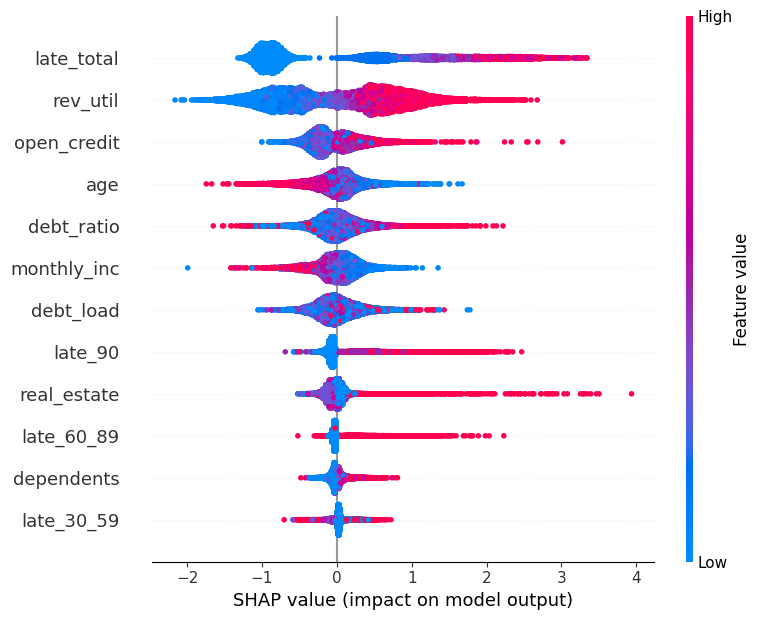

In [42]:
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

explainer = shap.Explainer(model)
shap_values = explainer(X_scaled)

shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Comparación de clusters (GMM y K-means)

Adjusted Rand Index (K-means vs GMM): 0.005


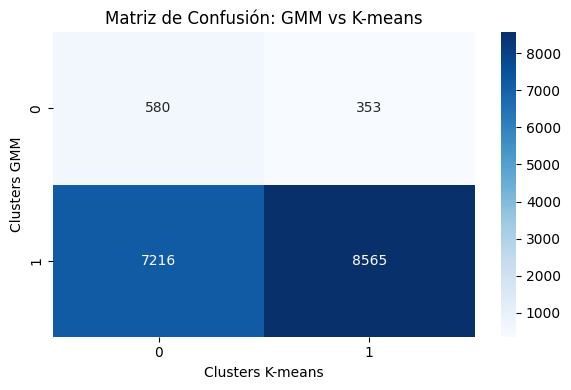

In [55]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

labels_df = pd.DataFrame({
    'kmeans': kmeans_labels,
    'gmm': gmm_labels
})

ari_kmeans_gmm = adjusted_rand_score(labels_df['kmeans'], labels_df['gmm'])
print(f"Adjusted Rand Index (K-means vs GMM): {ari_kmeans_gmm:.3f}")

conf_matrix = pd.crosstab(labels_df['gmm'], labels_df['kmeans'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión: GMM vs K-means')
plt.xlabel('Clusters K-means')
plt.ylabel('Clusters GMM')
plt.tight_layout()
plt.show()


# Clusters del GMM

(Tuvo el Silhouette más alto con el data set completo)

In [56]:
import pandas as pd

df_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['Silhouette'])
df_scores.sort_values(by='Silhouette', ascending=False)


,Silhouette
Jerárquico (subset),0.778840
GMM (X_scaled),0.559321
K-means (t-SNE),0.199617
K-means (X_scaled),0.189972
GMM (t-SNE),0.117459
Jerárquico (t-SNE subset),-0.052668


In [67]:
display(cluster_summary_gmm)


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs,late_total,debt_load,cluster_kmeans,cluster_hc
cluster_gmm,,,,,,,,,,,,,,,
0,0.642971,47.047160,10.439443,74.794037,4875.311897,9.103966,10.797428,1.904609,10.100750,0.926045,0.690247,31.337621,267761.841062,0.832797,1.904609
1,0.490234,48.902224,0.558710,0.368134,6063.203853,8.468221,0.276535,0.996768,0.180597,0.945441,0.488752,1.015842,2059.004144,1.044040,2.000000


El grupo 1 tiene más ingreso mensual (monthly_inc) que el grupo 0.

El grupo 0 tiene una mayor razón de deuda (debt_ratio) que el grupo 1.

El grupo 0 tiene más pagos atrasados (late_30_59) que el grupo 1.

El grupo 0 utiliza más el crédito rotativo (rev_util) que el grupo 1.

El grupo tiene una edad ligeramente mayor que el grupo 0.

In [68]:
display(cluster_summary_kmeans)


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs,late_total,debt_load,cluster_hc,cluster_gmm
cluster_kmeans,,,,,,,,,,,,,,,
0,0.759110,40.886993,1.864802,7.718083,4146.721780,5.478707,1.711262,0.477937,1.441380,1.052719,0.664828,5.017445,27750.817429,1.988584,0.925603
1,0.271165,55.714959,0.450662,1.729333,7614.290536,11.148127,0.123010,1.545302,0.116282,0.849630,0.355909,0.689953,7397.350239,2.000000,0.960417


El grupo 1 tiene más ingreso mensual (monthly_inc) que el grupo 0.

El grupo 0 tiene mayor morosidad (late_total, dlq_2yrs) que el grupo 1.

El grupo 0 utiliza más el crédito rotativo (rev_util) que el grupo 1.

El grupo 0 tiene más carga de deuda (debt_load) que el grupo 1.

El grupo 1 tiene más cuentas de crédito abiertas (open_credit) que el grupo 0.